# 用于文本分类的微调

内容大纲：
1. 构建数据集
   1. 下载数据集
   2. 平衡数据集中各个分类的数目
   3. 划分数据集
2. 创建数据加载器
3. 加载预训练的LLM
4. 修改模型结构以适应针对分类任务的微调
5. 检查模型的损失
6. 提取回复
7. 量化评估
8.  对回复打分
9.  LoRA微调

## 1. 构建数据集

本小节将会准备用于分类微调的数据集，我们将会构建包含垃圾短信和非垃圾短信的文本数据集.

In [1]:
from pathlib import Path 
import os
import zipfile

import requests


def download_and_unzip_spam_data(
    url: str,
    zip_path: str,
    extracted_path: str,
    data_file_path: Path
):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. We'll skip download and extraction.")
        return

    # 下载文件
    resp = requests.get(url)
    with open(zip_path, "wb") as out_file:
        out_file.write(resp.content)

    # 解压文件
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # 添加 .tsv 文件名后缀
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaed and saved as {data_file_path}")

In [2]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"
print(f"data file path: {data_file_path}")

download_and_unzip_spam_data(
    url=url,
    zip_path=zip_path,
    extracted_path=extracted_path,
    data_file_path=data_file_path
)

data file path: sms_spam_collection/SMSSpamCollection.tsv
sms_spam_collection/SMSSpamCollection.tsv already exists. We'll skip download and extraction.


使用 pandas 将 .tsv 文件读到内存中的 dataframe：

In [3]:
import pandas as pd 

df = pd.read_csv(
    data_file_path,
    sep="\t",
    header=None,
    names=["Label", "Text"]
)

df.head(n=10)

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


接着，我们看一下垃圾信息和非垃圾信息的分布：

In [4]:
df["Label"].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

可以看到，这两个类别的分布非常不均匀，所以我们需要平衡一下它们的比例。

### 1.2 平衡数据集中各个分类的数目

In [5]:
def create_balanced_dataset(df: pd.DataFrame):
    spam_set = df[df["Label"] == "spam"]
    ham_set = df[df["Label"] == "ham"]
    n_spam, n_ham = len(spam_set), len(ham_set)

    if n_spam > n_ham:
        spam_set = spam_set.sample(n=n_ham, random_state=123)
    else:
        ham_set = ham_set.sample(n=n_spam, random_state=123)

    balanced_df = pd.concat([spam_set, ham_set])
    return balanced_df

In [6]:
balanced_df = create_balanced_dataset(df=df)
balanced_df["Label"].value_counts()

Label
spam    747
ham     747
Name: count, dtype: int64

OK，现在两个类别的样本数目已经一致，接下来我们需要将字符类标签"ham"和"spam"更改为整数类标签0和1：

In [7]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
balanced_df

,Label,Text
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
5,1,FreeMsg Hey there darling it's been 3 week's n...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...
11,1,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
4707,0,Wow so healthy. Old airport rd lor. Cant thk o...
3293,0,Dear good morning how you feeling dear
1278,0,Dont put your phone on silent mode ok
4079,0,Gam gone after outstanding innings.


### 1.3 划分数据集

In [8]:
def split_dataset(
    df: pd.DataFrame,
    train_frac: float,
    valid_frac: float
):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    n = len(df)
    t = int(n * train_frac)
    v = t + int(n * valid_frac)

    train_df = df[:t]
    valid_df = df[t:v]
    test_df = df[v:]
    return train_df, valid_df, test_df

In [9]:
train_df, valid_df, test_df = split_dataset(
    df=balanced_df,
    train_frac=0.7,
    valid_frac=0.1
)

# 将各个数据集导出为csv文件：
train_df.to_csv("train.csv", index=None)
valid_df.to_csv("valid.csv", index=None)
test_df.to_csv("test.csv", index=None)

# 查看各个数据集的长度：
print(f"train set size: {len(train_df)}")
print(f"valid set size: {len(valid_df)}")
print(f"test set size: {len(test_df)}")

train set size: 1045
valid set size: 149
test set size: 300


## 2. 创建数据加载器

文本序列有不同的长度，在这里，我们将会将所有消息填充到数据集或者数据批中最长序列的长度。填充占位符使用”<|endoftext|>“来表示。

In [10]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
padding_token = "<|endoftext|>"
padding_token_id = tokenizer.encode(padding_token, allowed_special={padding_token})
print(f"padding token id: {padding_token_id}")

padding token id: [50256]


使用刚才的csv数据创建Dataset类：

In [11]:
from torch.utils.data import Dataset
import torch


class SpamDataset(Dataset):
    def __init__(
        self,
        csv_file: str,
        tokenizer: tiktoken.Encoding,
        max_length: int = None,
        padding_token_id: int = 50256
    ):
        self.data = pd.read_csv(csv_file)
        self.token_ids = [
            tokenizer.encode(token)
            for token in self.data["Text"]
        ]
        self.padding_token_id = padding_token_id
        # self.max_length = self._get_max_length()
        self.max_length = 0
        self._build_dataset(max_length=max_length)

    def _build_dataset(self, max_length: int = None):
        if max_length is None:
            self.max_length = self._get_max_length()
        else:
            self.max_length = max_length
        
        # 如果文本序列的长度大于 max_length，就截断它
        self.token_ids = [
            token[:self.max_length]
            for token in self.token_ids
        ]

        # 将文本序列填充到最长序列
        self.token_ids = [
            token + [self.padding_token_id] * (self.max_length - len(token))
            for token in self.token_ids
        ]

    def _get_max_length(self):
        max_len = 0
        for token in self.token_ids:
            length = len(token)
            max_len = max(max_len, length)
        return max_len

    def __getitem__(self, index):
        tokens = self.token_ids[index]  # token ids
        # labels = self.data.at[index, "Label"]
        labels = self.data.iloc[index]["Label"]
        return (
            torch.tensor(tokens, dtype=torch.long),
            torch.tensor(labels, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

OK，现在就可以分割数据集了：

In [12]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

valid_dataset = SpamDataset(
    csv_file="valid.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [13]:
print(f"train set's max length: {train_dataset.max_length}")
print(f"valid set's max length: {valid_dataset.max_length}")
print(f"test set's max length: {test_dataset.max_length}")

train set's max length: 120
valid set's max length: 120
test set's max length: 120


接下来就是创建批量数据的加载器：

In [14]:
from torch.utils.data import DataLoader

torch.manual_seed(123)
num_workers = 0
batch_size = 8

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    # shuffle=True,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    # shuffle=True,
    num_workers=num_workers,
    drop_last=False
)

In [15]:
print("train set loader:")
for ib, tb in train_loader:
    print(ib.shape)
    print(tb)
    break

print(f"train size: {len(train_loader.dataset)}")
print(f"valid size: {len(valid_loader.dataset)}")
print(f"test size: {len(test_loader.dataset)}")

train set loader:
torch.Size([8, 120])
tensor([1, 1, 0, 1, 1, 1, 0, 1])
train size: 1045
valid size: 149
test size: 300


## 3. 加载预训练的LLM

在这里，我们将会像上一章那样，将OpenAI开源的GPT2权重加载到我们自己实现的GPT2Small模型当中，并且，我们将会看到，在未经分类微调的情况下，预训练的模型在面对分类任务时的表现。

首先，我们需要加载模型：

In [16]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPT2Small, load_weights_into_gpt

model_config = {
    "vocab_size": 50257,
    "ctx_len": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "dropout_rate": 0.0,
    "with_bias": True,
    "with_mask": True
}
model_size = "124M"
_, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
model = GPT2Small(**model_config)
load_weights_into_gpt(gpt2=model, params=params)
model.eval();

验证模型是否已经成功加载：

In [17]:
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    indices=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=model_config["ctx_len"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of the work


然后，我们将会看到，未经过分类微调的大模型对文本分类任务无能为力：

In [18]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
    " Answer with 'yes' or 'no'."
)

token_ids = generate_text_simple(
    model=model,
    indices=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=model_config["ctx_len"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' Answer with 'yes' or 'no'. Answer with 'yes' or 'no'. Answer with 'yes' or 'no'. Answer with 'yes'


## 4. 修改模型结构以适应针对分类任务的微调

在这里，我们将会把原来预训练好的大模型的输出层由包含一个形状如(emb_dim, vocab_size)的线性层改为所包含的权重矩阵的形状为(emb_dim, num_classification)的线性层，同时，我们设置输出层、输出层前面的归一化层以及Decoder最后一个block为可训练的，而将其余层组件冻结。

首先，我们先来回顾一下预训练好的大模型的网络架构：

In [19]:
print(model)

GPT2Small(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (decoder): Sequential(
    (0): TransformerDecoderOnly(
      (drop): Dropout(p=0.0, inplace=False)
      (norm1): LayerNorm()
      (mha): MultiHeadAttention(
        (wq): Linear(in_features=768, out_features=768, bias=True)
        (wk): Linear(in_features=768, out_features=768, bias=True)
        (wv): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm2): LayerNorm()
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
          (3): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (1): TransformerDecoderOnly(
      (drop): Dropout(p=0.0, inplace=False)
      (norm1): LayerNorm()
      (mha)

接着，冻结所有层以标记为不可训练：

In [20]:
for param in model.parameters():
    param.requires_grad = False

再接着，我们需要如上述所说的那样替换输出层：

In [21]:
torch.manual_seed(123)

num_classes = 2
model.out = torch.nn.Linear(
    in_features=model_config["emb_dim"],
    out_features=num_classes
)
print(model.out.weight.shape)

torch.Size([2, 768])


然后，将最后一个decoder block以及最后一个归一化层标记为可训练：

In [22]:
for param in model.decoder[-1].parameters():
    param.requires_grad = True

for param in model.norm.parameters():
    param.requires_grad = True

最后，简单地测试一下模型的输入和输出：

In [23]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print(f"inputs: {inputs}")
print(f"inputs dimensions: {inputs.shape}")

with torch.no_grad():
    outputs = model(inputs)
print(f"outputs: {outputs}")
print(f"outputs' dimensions: {outputs.shape}")

print(f"last output token: {outputs[:, -1, :]}")

inputs: tensor([[5211,  345,  423,  640]])
inputs dimensions: torch.Size([1, 4])
outputs: tensor([[[-1.5854,  0.9903],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
outputs' dimensions: torch.Size([1, 4, 2])
last output token: tensor([[-3.5983,  3.9902]])


## 5. 计算分类准确率和分类损失

### 5.1 计算分类准确率

In [24]:
# def calc_accuracy_epoch(
#     data_loader,
#     model,
#     device,
#     num_batches=None
# ):
#     model.eval()
#     correct_predictions, num_samples = 0, 0
#     if num_batches is None:
#         num_batches = len(data_loader)
#     else:
#         num_batches = min(num_batches, len(data_loader))
#     for i, (input_batch, target_batch) in enumerate(data_loader):
#         if i < num_batches:
#             input_batch, target_batch = input_batch.to(device), target_batch.to(device)
#             with torch.no_grad():
#                 logits = model(input_batch)[:, -1, :]
#             predicted_labels = torch.argmax(logits, dim=-1)
#             num_samples += predicted_labels.shape[0]
#             correct_predictions += (predicted_labels == target_batch).sum().item()
#         else:
#             break
#     # model.train()
#     return correct_predictions / num_samples


def calc_accuracy_epoch(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # 最后输出标记的 Logits
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # nn.Module 类不需要分配 model = model.to(device)

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_epoch(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_epoch(valid_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_epoch(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 53.75%
Validation accuracy: 55.00%
Test accuracy: 51.25%


### 5.3 计算分类损失

计算单批数据的分类损失：


In [26]:

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # 只需要最后那个token的logits
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

计算整个数据集的分类损失：

In [27]:
def calc_loss_epoch(data_loader, model, device, num_batches=None):
    if len(data_loader) == 0:
        return float("nan")
    
    total_loss = 0.0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch=input_batch,
                target_batch=target_batch,
                model=model,
                device=device
            )
            total_loss += loss
        else:
            break
    return total_loss / num_batches

OK，现在可以计算微调之前的分类损失：

In [28]:
with torch.no_grad():
    train_loss = calc_loss_epoch(train_loader, model, device, num_batches=5)
    valid_loss = calc_loss_epoch(valid_loader, model, device, num_batches=5)
    test_loss = calc_loss_epoch(test_loader, model, device, num_batches=5)

print(f"train loss: {train_loss}")
print(F"valid loss: {valid_loss}")
print(f"test loss: {test_loss}")


train loss: 2.6862545013427734
valid loss: 2.578883647918701
test loss: 2.8424019813537598


## 6. 微调模型

### 6.1 定义用于微调的训练函数

In [29]:
# Same as chapter 5
def evaluate_model(
    model, 
    train_loader, 
    val_loader, 
    device, 
    eval_iter
):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_epoch(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_epoch(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def fine_tuning(
    model,
    train_loader,
    valid_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    tokenizer
):
    # 初始化用来跟踪损失以及已经训练过的样本
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    sample_seen = 0
    global_step = -1
    for e in range(num_epochs):
        model.train()
        for ib, tb in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(ib, tb, model, device)
            loss.backward()
            optimizer.step()
            sample_seen += ib.shape[0]
            global_step += 1
            # 评估收敛情况：
            if global_step % eval_freq == 0:
                train_loss, valid_loss = evaluate_model(
                    model=model,
                    train_loader=train_loader,
                    val_loader=valid_loader,
                    device=device,
                    eval_iter=eval_iter
                )
                train_losses.append(train_loss)
                valid_losses.append(valid_loss)
                print(f"Epoch {e + 1} (Step {global_step:06d}): Train loss: {train_loss:.3f}, Val loss: {valid_loss:.3f}")
        # 计算每个 epoch 后的准确率
        train_acc = calc_accuracy_epoch(train_loader, model, device, num_batches=eval_iter)
        valid_acc = calc_accuracy_epoch(valid_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_acc * 100:.2f}%, Valid accuracy: {valid_acc * 100:.2f}%")
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
    return train_losses, valid_losses, train_accs, valid_accs, sample_seen

### 6.2 进行微调训练

In [30]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = fine_tuning(
    model, train_loader, valid_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch 1 (Step 000000): Train loss: 2.628, Val loss: 2.387
Epoch 1 (Step 000050): Train loss: 0.667, Val loss: 0.651
Epoch 1 (Step 000100): Train loss: 0.677, Val loss: 0.544
Training accuracy: 65.00%, Valid accuracy: 67.50%
Epoch 2 (Step 000150): Train loss: 0.557, Val loss: 0.527
Epoch 2 (Step 000200): Train loss: 0.462, Val loss: 0.432
Epoch 2 (Step 000250): Train loss: 0.425, Val loss: 0.468
Training accuracy: 95.00%, Valid accuracy: 77.50%
Epoch 3 (Step 000300): Train loss: 0.369, Val loss: 0.421
Epoch 3 (Step 000350): Train loss: 0.381, Val loss: 0.441
Training accuracy: 90.00%, Valid accuracy: 82.50%
Epoch 4 (Step 000400): Train loss: 0.325, Val loss: 0.451
Epoch 4 (Step 000450): Train loss: 0.400, Val loss: 0.394
Epoch 4 (Step 000500): Train loss: 0.177, Val loss: 0.217
Training accuracy: 87.50%, Valid accuracy: 95.00%
Epoch 5 (Step 000550): Train loss: 0.267, Val loss: 0.116
Epoch 5 (Step 000600): Train loss: 0.069, Val loss: 0.104
Training accuracy: 97.50%, Valid accuracy: 95.

### 6.3 绘制收敛曲线

In [31]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 绘制针对 epoch 的训练和验证损失
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # 为所见示例创建第二个 x 轴
    ax2 = ax1.twiny()  # 创建共享相同 y 轴的第二个 x 轴
    ax2.plot(examples_seen, train_values, alpha=0)  # 用于对齐刻度的不可见图
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # 调整布局以腾出空间
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

绘制分类损失函数曲线：

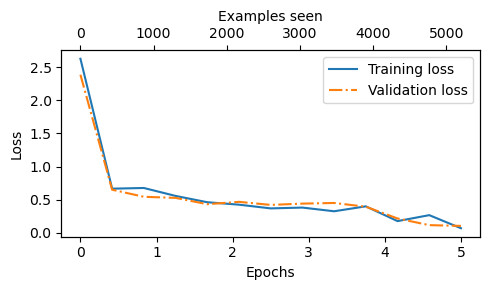

In [32]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

绘制分类损失精度曲线：

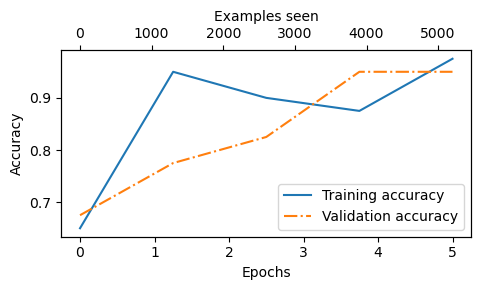

In [33]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

打印一下各个数据集的分类精度：

In [34]:
train_accuracy = calc_accuracy_epoch(train_loader, model, device)
val_accuracy = calc_accuracy_epoch(valid_loader, model, device)
test_accuracy = calc_accuracy_epoch(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 96.44%
Validation accuracy: 97.32%
Test accuracy: 97.67%


## 7. 测试经过微调的模型

In [35]:
def classify(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # 准备模型的输入
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    # 如果序列太长则截断
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # 将序列填充到最长序列
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # 添加批次维度

    # 模型推理
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # 最后一个输出 token 的 Logits
    predicted_label = torch.argmax(logits, dim=-1).item()

    # 返回分类结果
    return "spam" if predicted_label == 1 else "not spam"

跑几个消息看看是否是垃圾短信：

In [36]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify(
    text_1, 
    model, 
    tokenizer, 
    device, 
    max_length=train_dataset.max_length
))

spam


In [37]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify(
    text_2, 
    model, 
    tokenizer, 
    device, 
    max_length=train_dataset.max_length
))

not spam


最后，让我们保存一下微调好的模型！

In [38]:
torch.save(model.state_dict(), "text_classifier_based_on_gpt2_small.pth")